# Import Library & Port Forward

## Fetching Data from MySQL into a Pandas DataFrame

### Setup

Beberapa paket yang harus diinstall sebelum menjalankan program.
Anda bisa menginstall paket dibawah ini pada anaconda prompt atau jupyter notebook

paket `mysql-connector-python` untuk menyambung ke basis data MySQL dan paket `pandas` untuk bekerja dengan DataFrames
```bash
pip install mysql-connector-python
```

In [28]:
# install mysql connector di jupyter notebook
!pip install mysql-connector-python

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import mysql.connector
from mysql.connector import Error

# import warning to ignore warning
import warnings
warnings.filterwarnings('ignore')

In [30]:
# Fungsi untuk mengkoneksikan ke database
def connect_to_db(host_name, port_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            port=port_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

In [31]:
# define mysql details
host   = 'okegarden-laravel-prod-db-2024-11-15-0200.cgwhhgh85mr3.ap-southeast-3.rds.amazonaws.com'
port   = 3306
user   = 'intern_mes'
passwd = 'sdfDFLES342982Ddlsdksd'
databs = 'okegarden_laravel_prod_db'

In [32]:
# mencoba terkoneksi dengan database
connect_to_db(host, port, user, passwd, databs)

MySQL Database connection successful


## Writing the Function to Fetch Data

In [34]:
# berfungsi untuk mengambil data dari database, koneksi ditutup setelah digunakan.
def fetch_data(host_name, port_name, user_name, user_password, db_name, query, params=None):
    try:
        with mysql.connector.connect(
            host=host_name,
            port=port_name,
            user=user_name,
            password=user_password,
            database=db_name
        ) as connection:
            data = pd.read_sql(query, connection, params=params)
            return data

    except Error as e:
        print(f"Error while connecting to MySQL or fetching data: {e}")
        return None

# Assessing Data

In [36]:
# Mendefinisikan master query
master_query = """

SELECT
   DATE(order_garden.created_at) AS date,
   order_garden.id_order,
   order_garden.id_user,
   design.design_name,
   order_garden.size_area,
   CASE
       WHEN order_garden.price = 0 THEN order_garden.total_promo
       ELSE order_garden.price
   END AS revenue,
   desc_design.total_item_cost,
   CASE
       WHEN order_garden.size_area <= 10 THEN 2
       WHEN order_garden.size_area BETWEEN 11 AND 20 THEN 3
       WHEN order_garden.size_area BETWEEN 21 AND 30 THEN 4
       WHEN order_garden.size_area BETWEEN 31 AND 40 THEN 5
       WHEN order_garden.size_area BETWEEN 41 AND 50 THEN 5
       ELSE 5
   END AS jumlah_tenaga_kerja,
   CASE
       WHEN order_garden.size_area <= 10 THEN 2 * 250000
       WHEN order_garden.size_area BETWEEN 11 AND 20 THEN 3 * 250000
       WHEN order_garden.size_area BETWEEN 21 AND 30 THEN 4 * 250000
       WHEN order_garden.size_area BETWEEN 31 AND 40 THEN 5 * 250000
       WHEN order_garden.size_area BETWEEN 41 AND 50 THEN 5 * 250000
       ELSE 5 * 250000
   END AS total_biaya_tenaga_kerja,
   (CASE
       WHEN order_garden.size_area <= 10 THEN 2 * 250000
       WHEN order_garden.size_area BETWEEN 11 AND 20 THEN 3 * 250000
       WHEN order_garden.size_area BETWEEN 21 AND 30 THEN 4 * 250000
       WHEN order_garden.size_area BETWEEN 31 AND 40 THEN 5 * 250000
       WHEN order_garden.size_area BETWEEN 41 AND 50 THEN 5 * 250000
       ELSE 5 * 250000
   END + desc_design.total_item_cost) AS cogs,
   ((CASE
       WHEN order_garden.price = 0 THEN order_garden.total_promo
       ELSE order_garden.price
   END) -
   (CASE
       WHEN order_garden.size_area <= 10 THEN 2 * 250000
       WHEN order_garden.size_area BETWEEN 11 AND 20 THEN 3 * 250000
       WHEN order_garden.size_area BETWEEN 21 AND 30 THEN 4 * 250000
       WHEN order_garden.size_area BETWEEN 31 AND 40 THEN 5 * 250000
       WHEN order_garden.size_area BETWEEN 41 AND 50 THEN 5 * 250000
       ELSE 5 * 250000
   END + desc_design.total_item_cost)) AS gross_profit,
   order_garden.status,
   order_garden.id_gardener,
   u.name,
   address_components.administrative_area_level_1 AS province,
   address_components.administrative_area_level_2 AS city,
   address_components.administrative_area_level_3 AS district
FROM
   `order_garden`
JOIN
   `design` on design.id_design = order_garden.id_design_finish
LEFT JOIN
   (
       SELECT
           id_design,
           SUM(item_total_cost) AS total_item_cost
       FROM
           desc_design
       GROUP BY
           id_design
   ) desc_design ON design.id_design = desc_design.id_design
LEFT JOIN
   `user` u on order_garden.id_gardener = u.id_user
LEFT JOIN
   `address_components` on order_garden.id_order = address_components.address_componentable_id
WHERE
	order_garden.status != "expired"
	AND
	order_garden.id_user >= 250;

"""

In [37]:
# fetch data menggunakan fungsi
df = fetch_data(host, port, user, passwd, databs, master_query)

In [38]:
# menampilkan data
df.head()

,date,id_order,id_user,design_name,size_area,revenue,total_item_cost,jumlah_tenaga_kerja,total_biaya_tenaga_kerja,cogs,gross_profit,status,id_gardener,name,province,city,district
0,2024-04-23,65,927,Taman Regina,11.0,9230382.0,4463700.0,3,750000,5213700.0,4016682.0,in_review,1087.0,ODIH,Jakarta,East Jakarta City,Cakung
1,2024-04-27,66,926,Taman Susy,28.0,6581190.0,2646250.0,4,1000000,3646250.0,2934940.0,in_review,1093.0,Budi Wahyudi,Banten,South Tangerang City,Ciputat
2,2024-05-16,70,925,Taman Lintang R,35.0,11550859.0,3931899.0,5,1250000,5181899.0,6368960.0,finish,1085.0,Ari aryana,West Java,Bekasi,Pondok Melati
3,2024-05-24,72,1024,Taman Nopri,2.0,5440942.0,2987200.0,2,500000,3487200.0,1953742.0,finish,1087.0,ODIH,Banten,Tangerang Regency,Sindang Jaya
4,2024-06-12,74,1052,Taman Nur Atikah,5.0,4334875.0,2331500.0,2,500000,2831500.0,1503375.0,finish,1087.0,ODIH,Banten,Tangerang Regency,


In [39]:
# menampilkan informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      196 non-null    object 
 1   id_order                  196 non-null    int64  
 2   id_user                   196 non-null    int64  
 3   design_name               196 non-null    object 
 4   size_area                 196 non-null    float64
 5   revenue                   196 non-null    float64
 6   total_item_cost           196 non-null    float64
 7   jumlah_tenaga_kerja       196 non-null    int64  
 8   total_biaya_tenaga_kerja  196 non-null    int64  
 9   cogs                      196 non-null    float64
 10  gross_profit              196 non-null    float64
 11  status                    196 non-null    object 
 12  id_gardener               185 non-null    float64
 13  name                      185 non-null    object 
 14  province  

## Missing Values

In [41]:
# Mengecek jumlah nilai kosong di setiap kolom
df.isna().sum()

date                         0
id_order                     0
id_user                      0
design_name                  0
size_area                    0
revenue                      0
total_item_cost              0
jumlah_tenaga_kerja          0
total_biaya_tenaga_kerja     0
cogs                         0
gross_profit                 0
status                       0
id_gardener                 11
name                        11
province                     0
city                         0
district                     0
dtype: int64

## Duplicates

In [43]:
# Mengecek jumlah baris duplikat dalam dataframe
print("Jumlah duplikasi: ", df.duplicated().sum())

Jumlah duplikasi:  2


## Outliers

In [45]:
# Memilih kolom dengan tipe data numerik (integer dan float)
df_num = df.select_dtypes(include =['int64', 'float64'])

In [46]:
# Fungsi untuk menemukan outlier menggunakan metode IQR
def find_outlier(data):
    Q1 = np.quantile(data, .25)
    Q3 = np.quantile(data, .75)
    IQR = (Q3 - Q1) * 1.5
    lower_limit = Q1 - IQR
    upper_limit = Q3 + IQR

    outlier = ''
    for i in range(len(data)):
        if data[i] > upper_limit or data[i] < lower_limit:
            outlier += str(data[i]) + ', '

    return outlier

In [47]:
# Menampilkan jumlah outlier untuk setiap kolom numerik
for i in df_num:
    val = df_num[i].sort_values().values.tolist()
    print(f"Outliers Detected {i}: ", len(find_outlier(val)))

Outliers Detected id_order:  0
Outliers Detected id_user:  0
Outliers Detected size_area:  112
Outliers Detected revenue:  240
Outliers Detected total_item_cost:  260
Outliers Detected jumlah_tenaga_kerja:  60
Outliers Detected total_biaya_tenaga_kerja:  180
Outliers Detected cogs:  216
Outliers Detected gross_profit:  192
Outliers Detected id_gardener:  0


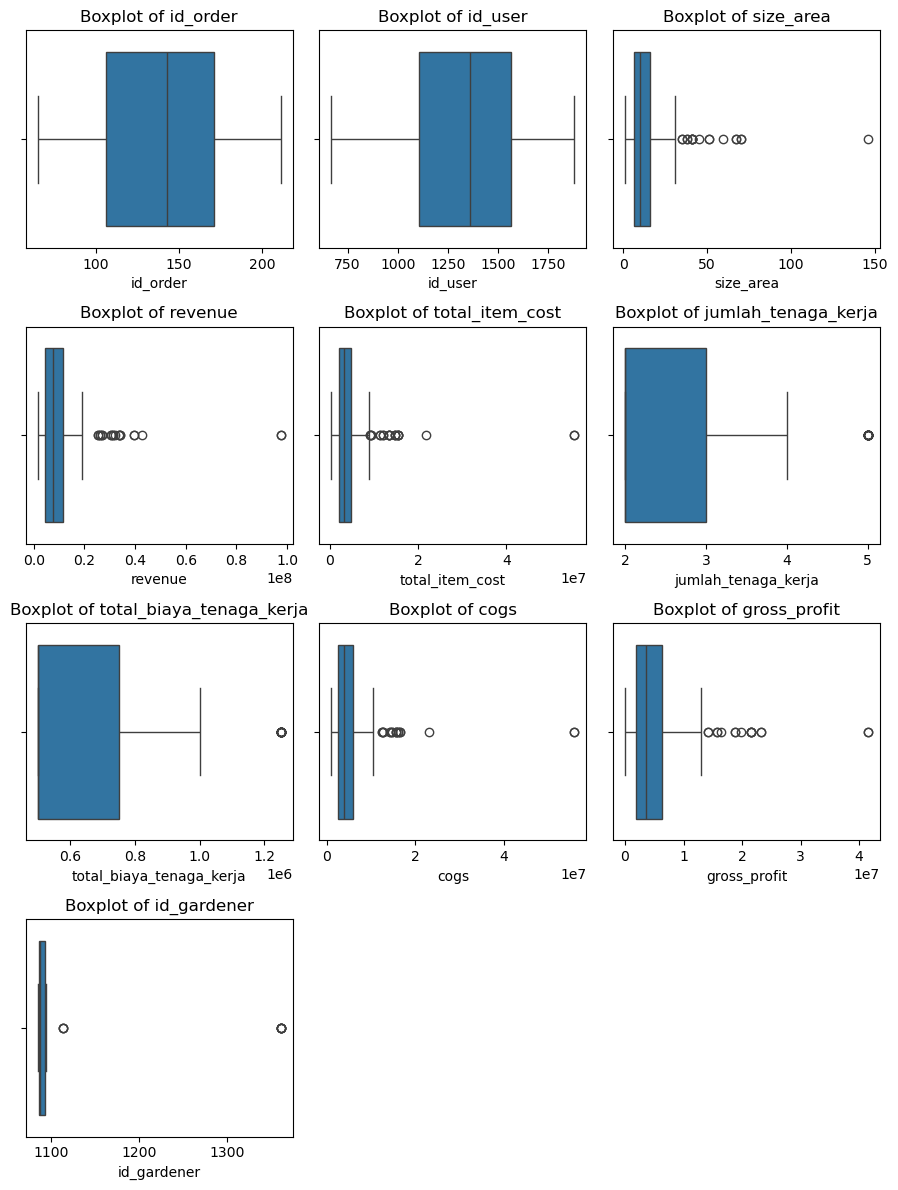

In [48]:
# Menampilkan boxplot untuk setiap kolom numerik dalam dataframe
num_cols = 3
num_rows = (len(df_num.columns) + num_cols - 1) // num_cols
plt.figure(figsize=(3 * num_cols, 3 * num_rows))

for i, column in enumerate(df_num.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(data=df_num, x=column)
    plt.title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

# Cleaning & Data Transformation

### Type casting

In [51]:
# Mengubah tipe data kolom sesuai kebutuhan
df['date'] = pd.to_datetime(df['date'])  # Mengubah 'date' menjadi datetime
df['revenue'] = df['revenue'].astype('int64')  # Mengubah 'revenue' menjadi integer
df['total_item_cost'] = df['total_item_cost'].astype('int64')  # Mengubah 'total_item_cost' menjadi integer
df['cogs'] = df['cogs'].astype('int64')  # Mengubah 'cogs' menjadi integer
df['gross_profit'] = df['gross_profit'].astype('int64')  # Mengubah 'gross_profit' menjadi integer

In [52]:
# menampilkan informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      196 non-null    datetime64[ns]
 1   id_order                  196 non-null    int64         
 2   id_user                   196 non-null    int64         
 3   design_name               196 non-null    object        
 4   size_area                 196 non-null    float64       
 5   revenue                   196 non-null    int64         
 6   total_item_cost           196 non-null    int64         
 7   jumlah_tenaga_kerja       196 non-null    int64         
 8   total_biaya_tenaga_kerja  196 non-null    int64         
 9   cogs                      196 non-null    int64         
 10  gross_profit              196 non-null    int64         
 11  status                    196 non-null    object        
 12  id_gardener           

### Handling Missing Values

In [54]:
# Mengisi nilai kosong pada 'id_gardener' dengan 0 dan mengubah tipe datanya menjadi int64
df['id_gardener'] = df['id_gardener'].fillna(0)  # Mengisi NaN dengan 0
df['id_gardener'] = df['id_gardener'].astype('int64')  # Mengubah 'id_gardener' menjadi integer

In [55]:
# Mengisi nilai kosong pada kolom 'name' dengan 'none'
df['name'] = df['name'].fillna('none')

In [56]:
# Mengecek jumlah nilai kosong di setiap kolom
df.isna().sum()

date                        0
id_order                    0
id_user                     0
design_name                 0
size_area                   0
revenue                     0
total_item_cost             0
jumlah_tenaga_kerja         0
total_biaya_tenaga_kerja    0
cogs                        0
gross_profit                0
status                      0
id_gardener                 0
name                        0
province                    0
city                        0
district                    0
dtype: int64

### Handline duplicate

In [58]:
# Menghapus baris duplikat dan menampilkan jumlah duplikasi setelah dihapus
df.drop_duplicates(inplace=True)  # Menghapus baris duplikat
print("Jumlah duplikasi setelah dihapus: ", df.duplicated().sum())  # Menampilkan jumlah duplikasi

Jumlah duplikasi setelah dihapus:  0


### Transformation

In [60]:
# Transformasi nama pada kolom 'province', 'city', dan 'district' menggunakan mapping
province_transform = {
    'Daerah Khusus Ibukota Jakarta': 'Jakarta',
    'West Java': 'Jawa Barat',
    'East Java': 'Jawa Timur',
    '': 'none'
}

city_transform = {
    'South Tangerang City': 'Tangerang Selatan',
    'West Jakarta City': 'Jakarta Barat',
    'North Jakarta City': 'Jakarta Utara',
    'Denpasar City': 'Denpasar',
    'Depok City': 'Depok',
    'East Jakarta City': 'Jakarta Timur',
    'South Jakarta City': 'Jakarta Selatan',
    'Tangerang City': 'Tangerang',
    'Tangerang Regency': 'Kabupaten Tangerang',
    'Bekasi Regency': 'Kabupaten Bekasi',
    'Ciamis Regency': 'Kabupaten Ciamis',
    'Badung Regency': 'Kabupaten Badung',
    'Tabanan Regency': 'Kabupaten Tabanan',
    'Malang City': 'Malang',
    '': 'none'
}

district_transform = {
    'Kebonjeruk': 'Kebon Jeruk',
    'Serpong Sub-District': 'Serpong',
    'South Kuta': 'Kuta Selatan',
    '': 'none'
}

In [61]:
# Mengganti nilai pada kolom 'province', 'city', dan 'district' sesuai dengan mapping yang sudah didefinisikan
df['province'] = df['province'].replace(province_transform)
df['city'] = df['city'].replace(city_transform)
df['district'] = df['district'].replace(district_transform)

In [62]:
# Menghapus baris yang memiliki nilai 'none' di kolom 'province', 'city', atau 'district'
df = df[~((df['province'] == 'none') | (df['city'] == 'none') | (df['district'] == 'none'))]

# Exploratory Data Analysis (EDA)

## Descriptive Analysis

In [65]:
# Menampilkan statistik deskriptif untuk kolom selain 'id_order', 'id_user', dan 'id_gardener'
df.describe().drop(['id_order', 'id_user', 'id_gardener'], axis=1)

,date,size_area,revenue,total_item_cost,jumlah_tenaga_kerja,total_biaya_tenaga_kerja,cogs,gross_profit
count,182,182.000000,1.820000e+02,1.820000e+02,182.000000,1.820000e+02,1.820000e+02,1.820000e+02
mean,2024-08-25 03:09:53.406593280,14.491621,1.072127e+07,4.907772e+06,2.796703,6.991758e+05,5.606948e+06,5.114325e+06
min,2024-04-23 00:00:00,1.000000,1.625150e+06,3.570000e+05,2.000000,5.000000e+05,1.087700e+06,1.815000e+04
25%,2024-07-19 00:00:00,6.000000,4.615075e+06,2.121000e+06,2.000000,5.000000e+05,2.661180e+06,1.846609e+06
50%,2024-08-26 00:00:00,10.000000,7.667025e+06,3.266449e+06,2.000000,5.000000e+05,3.987988e+06,3.427525e+06
75%,2024-09-30 00:00:00,16.000000,1.154362e+07,4.765900e+06,3.000000,7.500000e+05,5.769238e+06,6.266946e+06
max,2024-11-14 00:00:00,145.725000,9.741224e+07,5.539690e+07,5.000000,1.250000e+06,5.589690e+07,4.151534e+07
std,NaN,16.222890,1.215627e+07,6.406464e+06,1.001320,2.503299e+05,6.463978e+06,6.036441e+06


In [66]:
# Menghitung rata-rata (mean) untuk kolom numerik selain 'id_order', 'id_user', dan 'id_gardener'
mean_values = df.select_dtypes(['number']).drop(['id_order', 'id_user', 'id_gardener'], axis=1).mean()
mean_values

size_area                   1.449162e+01
revenue                     1.072127e+07
total_item_cost             4.907772e+06
jumlah_tenaga_kerja         2.796703e+00
total_biaya_tenaga_kerja    6.991758e+05
cogs                        5.606948e+06
gross_profit                5.114325e+06
dtype: float64

In [67]:
# Menghitung nilai median untuk kolom numerik selain 'id_order', 'id_user', dan 'id_gardener'
median_values = df.select_dtypes(['number']).drop(['id_order', 'id_user', 'id_gardener'], axis=1).median()
median_values

size_area                        10.0
revenue                     7667025.0
total_item_cost             3266449.0
jumlah_tenaga_kerja               2.0
total_biaya_tenaga_kerja     500000.0
cogs                        3987987.5
gross_profit                3427525.0
dtype: float64

In [68]:
# Menghitung nilai modus untuk kolom numerik selain 'id_order', 'id_user', dan 'id_gardener'
mode_values = df.select_dtypes(['number']).drop(['id_order', 'id_user', 'id_gardener'], axis=1).mode()
mode_values

,size_area,revenue,total_item_cost,jumlah_tenaga_kerja,total_biaya_tenaga_kerja,cogs,gross_profit
0,11.0,8912900,4218600,2.0,500000.0,4848210,3944300
1,NaN,9656270,4348210,NaN,NaN,4968600,4808060


### Range

In [70]:
# Menghitung rentang (max - min) untuk kolom numerik selain kolom yang ada di 'dropped'
dropped = ['id_order', 'id_user', 'id_gardener']
df.select_dtypes(['number']).drop(dropped, axis=1).max() - df.select_dtypes(['number']).drop(dropped, axis=1).min()

size_area                   1.447250e+02
revenue                     9.578709e+07
total_item_cost             5.503990e+07
jumlah_tenaga_kerja         3.000000e+00
total_biaya_tenaga_kerja    7.500000e+05
cogs                        5.480920e+07
gross_profit                4.149719e+07
dtype: float64

In [71]:
print(df['size_area'].max(), df['size_area'].min())
print("Range of size_area :", df['size_area'].max() - df['size_area'].min())

145.725 1.0
Range of size_area : 144.725


In [72]:
print(df['revenue'].max(), df['revenue'].min())
print("Range of price :", df['revenue'].max() - df['revenue'].min())

97412240 1625150
Range of price : 95787090


In [73]:
print(df['total_item_cost'].max(), df['total_item_cost'].min())
print("Range of total_item_cost :", df['total_item_cost'].max() - df['total_item_cost'].min())

55396899 357000
Range of total_item_cost : 55039899


In [74]:
print(df['jumlah_tenaga_kerja'].max(), df['jumlah_tenaga_kerja'].min())
print("Range of jumlah_tenaga_kerja :", df['jumlah_tenaga_kerja'].max() - df['jumlah_tenaga_kerja'].min())

5 2
Range of jumlah_tenaga_kerja : 3


In [75]:
print(df['total_biaya_tenaga_kerja'].max(), df['total_biaya_tenaga_kerja'].min())
print("Range of total_biaya_tenaga_kerja :", df['total_biaya_tenaga_kerja'].max() - df['total_biaya_tenaga_kerja'].min())

1250000 500000
Range of total_biaya_tenaga_kerja : 750000


In [76]:
print(df['cogs'].max(), df['cogs'].min())
print("Range of cogs :", df['cogs'].max() - df['cogs'].min())

55896899 1087700
Range of cogs : 54809199


In [77]:
print(df['gross_profit'].max(), df['gross_profit'].min())
print("Range of gross_profit :", df['gross_profit'].max() - df['gross_profit'].min())

41515341 18150
Range of gross_profit : 41497191


### Standard Deviation

In [79]:
# Menghitung nilai standar deviasi untuk kolom numerik selain 'id_order', 'id_user', dan 'id_gardener'
df.select_dtypes(['number']).drop(['id_order', 'id_user', 'id_gardener'], axis=1).std()

size_area                   1.622289e+01
revenue                     1.215627e+07
total_item_cost             6.406464e+06
jumlah_tenaga_kerja         1.001320e+00
total_biaya_tenaga_kerja    2.503299e+05
cogs                        6.463978e+06
gross_profit                6.036441e+06
dtype: float64

### Variance

In [81]:
# Menghitung varians untuk kolom numerik selain 'id_order', 'id_user', dan 'id_gardener'
df.select_dtypes(['number']).drop(['id_order', 'id_user', 'id_gardener'], axis=1).var()

size_area                   2.631822e+02
revenue                     1.477749e+14
total_item_cost             4.104278e+13
jumlah_tenaga_kerja         1.002641e+00
total_biaya_tenaga_kerja    6.266506e+10
cogs                        4.178301e+13
gross_profit                3.643862e+13
dtype: float64

### Distribution

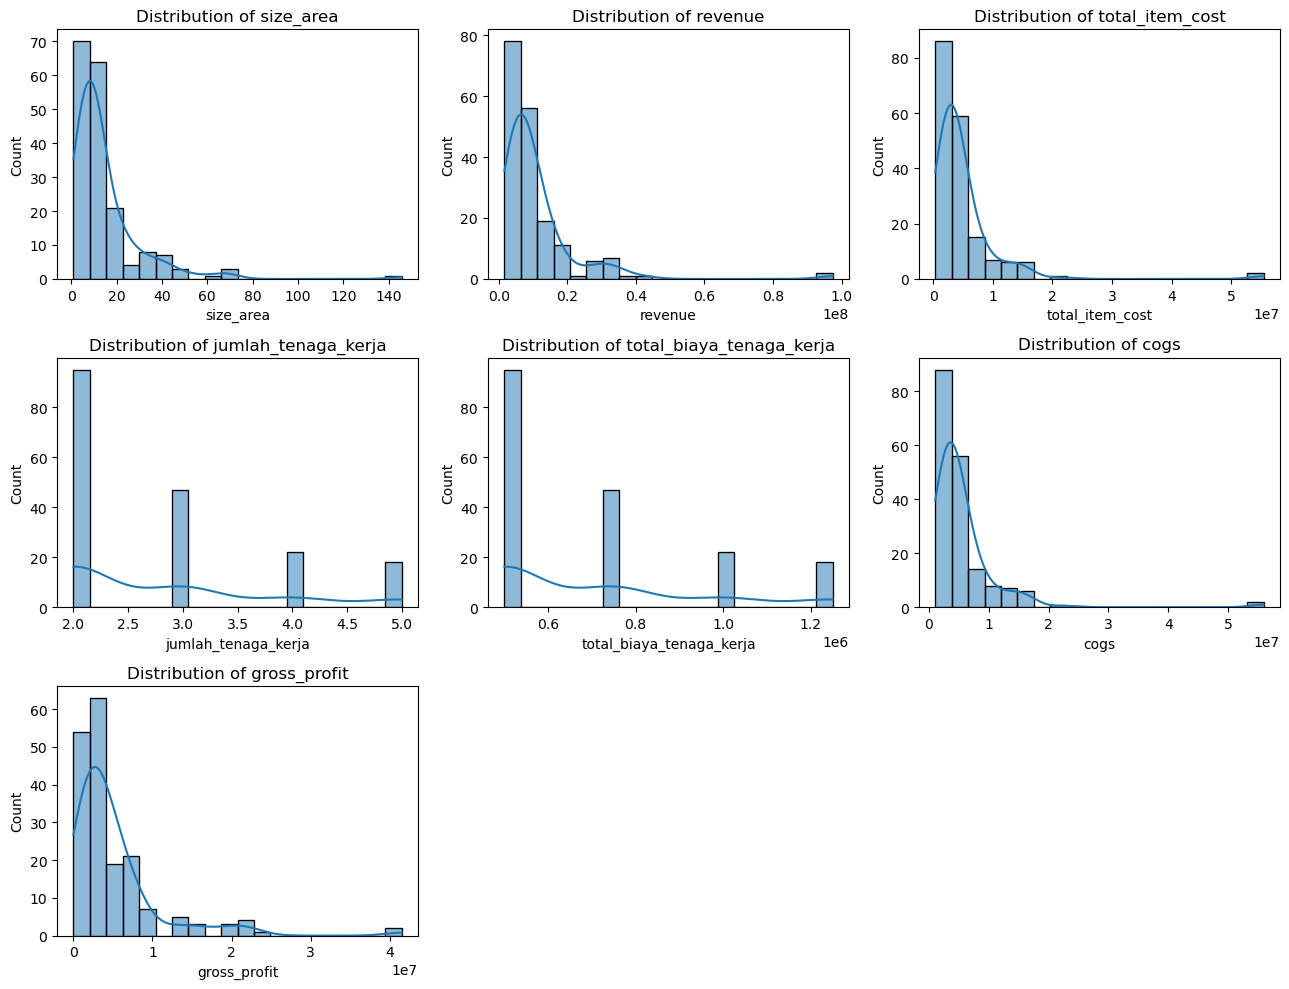

In [83]:
# Menampilkan histogram dengan distribusi dan KDE untuk beberapa kolom dalam dataframe
plt.figure(figsize=(13, 10))

# Plot untuk 'size_area'
plt.subplot(3, 3, 1)
sns.histplot(df['size_area'], bins=20, kde=True)
plt.title('Distribution of size_area')

# Plot untuk 'revenue'
plt.subplot(3, 3, 2)
sns.histplot(df['revenue'], bins=20, kde=True)
plt.title('Distribution of revenue')

# Plot untuk 'total_item_cost'
plt.subplot(3, 3, 3)
sns.histplot(df['total_item_cost'], bins=20, kde=True)
plt.title('Distribution of total_item_cost')

# Plot untuk 'jumlah_tenaga_kerja'
plt.subplot(3, 3, 4)
sns.histplot(df['jumlah_tenaga_kerja'], bins=20, kde=True)
plt.title('Distribution of jumlah_tenaga_kerja')

# Plot untuk 'total_biaya_tenaga_kerja'
plt.subplot(3, 3, 5)
sns.histplot(df['total_biaya_tenaga_kerja'], bins=20, kde=True)
plt.title('Distribution of total_biaya_tenaga_kerja')

# Plot untuk 'cogs'
plt.subplot(3, 3, 6)
sns.histplot(df['cogs'], bins=20, kde=True)
plt.title('Distribution of cogs')

# Plot untuk 'gross_profit'
plt.subplot(3, 3, 7)
sns.histplot(df['gross_profit'], bins=20, kde=True)
plt.title('Distribution of gross_profit')

# Atur layout dan tampilkan plot
plt.tight_layout()
plt.show()

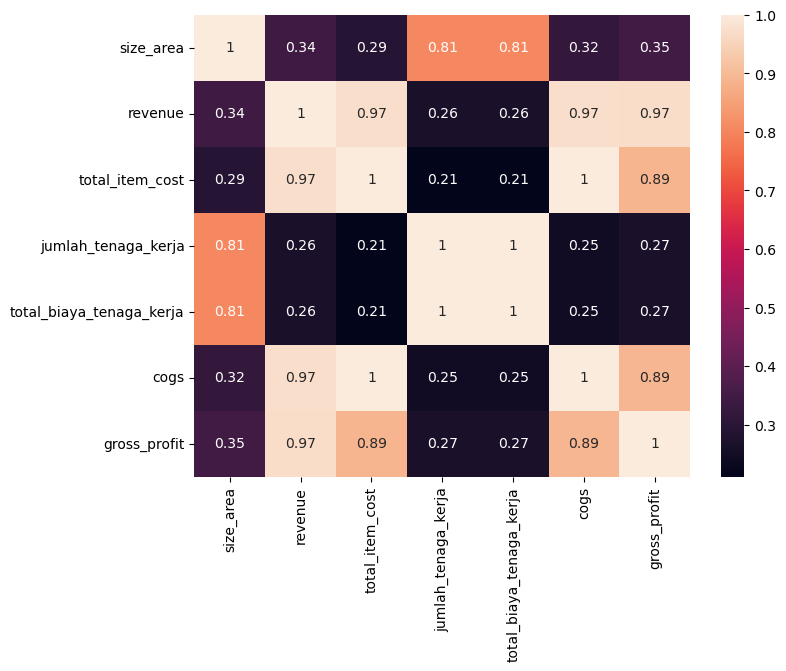

In [84]:
# Menampilkan heatmap korelasi antar kolom numerik yang relevan
plt.figure(figsize=(8,6))
sns.heatmap(df[["size_area", "revenue", "total_item_cost", "jumlah_tenaga_kerja", "total_biaya_tenaga_kerja", "cogs", "gross_profit"]].corr(), annot=True)
plt.show()

# Insight

### Tren order pembuatan taman dari waktu ke waktu berdasarka lokasi

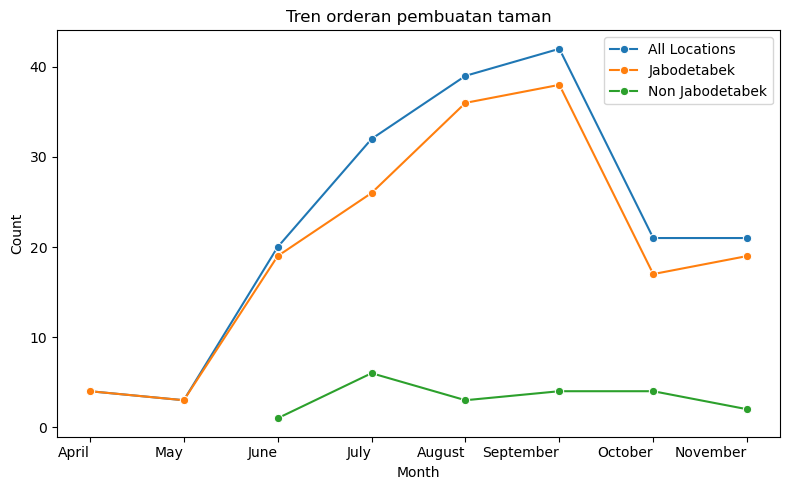

In [87]:
# Menambahkan kolom 'month' berdasarkan tanggal
df['month'] = df['date'].dt.to_period('M')

# Menghitung jumlah pesanan per bulan untuk semua lokasi
monthly_orders = df.groupby('month')['id_order'].count()

# Daftar kota Jabodetabek
jabodetabek_cities = ['Jakarta', 'Bogor', 'Depok', 'Tangerang', 'Bekasi',
                       'Jakarta Barat', 'Jakarta Utara', 'Jakarta Timur', 'Jakarta Selatan',
                       'Tangerang Selatan', 'Kabupaten Tangerang', 'Kabupaten Bekasi']

# Menghitung jumlah pesanan per bulan untuk Jabodetabek
jabodetabek_orders = df[df['city'].isin(jabodetabek_cities)].groupby('month')['id_order'].count()

# Menghitung jumlah pesanan per bulan untuk luar Jabodetabek
outside_jabodetabek_orders = df[~df['city'].isin(jabodetabek_cities)].groupby('month')['id_order'].count()

# Plot trend jumlah pesanan
plt.figure(figsize=(8, 5))
sns.lineplot(x=monthly_orders.index.astype(str), y=monthly_orders.values, label='All Locations', marker='o')
sns.lineplot(x=jabodetabek_orders.index.astype(str), y=jabodetabek_orders.values, label='Jabodetabek', marker='o')
sns.lineplot(x=outside_jabodetabek_orders.index.astype(str), y=outside_jabodetabek_orders.values, label='Non Jabodetabek', marker='o')

# Menampilkan nama bulan pada x-axis
month_names = [period.strftime('%B') for period in monthly_orders.index]
plt.xticks(range(len(month_names)), month_names, ha='right')

# Menambahkan label dan judul
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Tren orderan pembuatan taman')
plt.legend()

# Atur layout dan tampilkan plot
plt.tight_layout()
plt.show()

### Tren pertumbuhan revenue & gross profit dari waktu ke waktu

In [89]:
# Mengelompokkan data berdasarkan bulan dan menghitung total 'gross_profit' dan 'revenue'
monthly_data = df.groupby(pd.Grouper(key='date', freq='M'))[['gross_profit', 'revenue']].sum().reset_index()

# Mengkonversi 'gross_profit' dan 'revenue' menjadi satuan juta
monthly_data['gross_profit'] = monthly_data['gross_profit'] / 1000000
monthly_data['revenue'] = monthly_data['revenue'] / 1000000

# Menampilkan data bulanan
monthly_data

,date,gross_profit,revenue
0,2024-04-30,13.903244,31.623144
1,2024-05-31,14.691662,28.542660
2,2024-06-30,131.335557,307.767789
3,2024-07-31,136.012994,289.372612
4,2024-08-31,202.042987,388.834008
5,2024-09-30,229.605301,462.797240
6,2024-10-31,75.977634,169.069474
7,2024-11-30,127.237704,273.264678


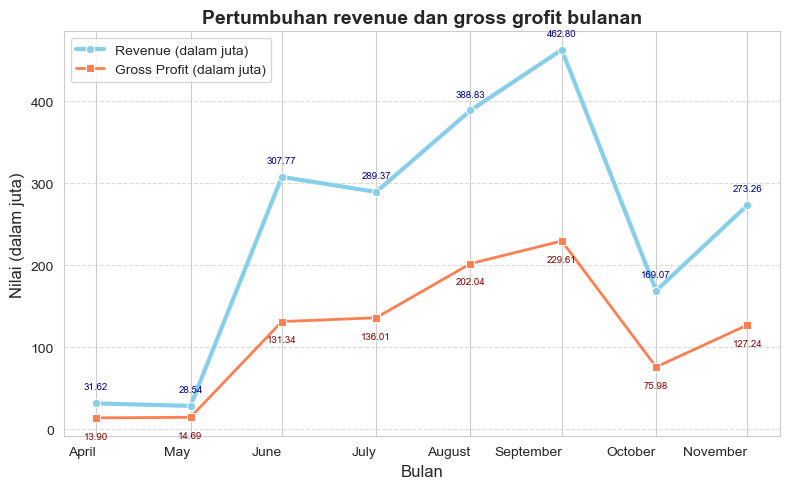

In [90]:
# Membuat plot untuk revenue dan gross profit per bulan
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

# Plot garis untuk revenue
sns.lineplot(x='date', y='revenue', data=monthly_data, label='Revenue (dalam juta)', marker='o', color='skyblue', linewidth=3)

# Plot garis untuk gross profit
sns.lineplot(x='date', y='gross_profit', data=monthly_data, label='Gross Profit (dalam juta)', marker='s', color='coral', linewidth=2)

# Memberikan label pada sumbu x dan y serta judul grafik
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Nilai (dalam juta)', fontsize=12)
plt.title('Pertumbuhan revenue dan gross grofit bulanan', fontsize=14, fontweight='bold')

# Menambahkan legends dan grid pada sumbu y
plt.legend(loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mengubah kolom date menjadi format datetime
monthly_data['date'] = pd.to_datetime(monthly_data['date'])

# Mengubah format bulan menjadi nama bulan
month_names = monthly_data['date'].dt.strftime('%B')
plt.xticks(monthly_data['date'], month_names, ha='right')

# Menambahkan anotasi pada setiap titik data
for index, row in monthly_data.iterrows():
    plt.annotate(f"{row['revenue']:.2f}", (row['date'], row['revenue']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=7, color='darkblue')
    plt.annotate(f"{row['gross_profit']:.2f}", (row['date'], row['gross_profit']), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=7, color='darkred')

# Menyesuaikan layout dan menampilkan plot
plt.tight_layout()
plt.show()

### Persentase order pembuatan taman berdasarkan provinsi

In [92]:
province_order_counts = df['province'].value_counts()
province_order_counts

province
Jawa Barat    61
Jakarta       60
Banten        55
Jawa Timur     5
Bali           1
Name: count, dtype: int64

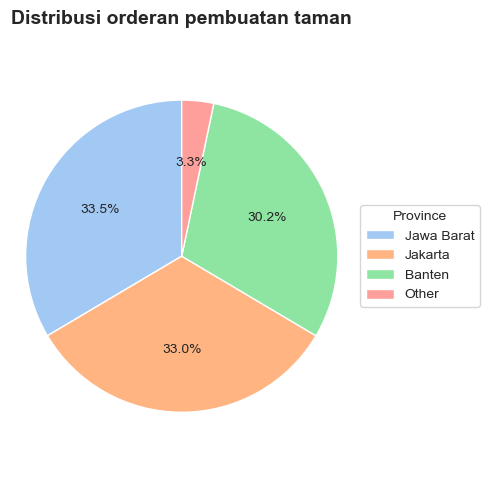

In [93]:
# Menampilkan 3 provinsi dengan jumlah pesanan terbanyak
top_3_provinces = province_order_counts.head(3)

# Menghitung jumlah pesanan dari provinsi lainnya dan menggabungkannya dengan top 3 provinsi
other_provinces_sum = province_order_counts.iloc[3:].sum()
province_order_counts_modified = pd.concat([top_3_provinces, pd.Series({'Other': other_provinces_sum})])

# Membuat pie chart untuk distribusi pesanan berdasarkan provinsi
plt.figure(figsize=(5, 5))
colors = sns.color_palette('pastel')
wedges, texts, autotexts = plt.pie(province_order_counts_modified, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
plt.legend(wedges, province_order_counts_modified.index, title="Province", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribusi orderan pembuatan taman', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

### Kota dengan orderan pembuatan taman tertinggi

In [95]:
# Menghitung jumlah pesanan per kota
city_order_counts = df['city'].value_counts()
top_10_cities = city_order_counts.head(10)
top_10_cities

city
Bekasi               30
Tangerang Selatan    28
Tangerang            21
Jakarta Selatan      19
Depok                18
Jakarta Timur        12
Jakarta Barat        12
Jakarta Utara         9
Jakarta Pusat         8
Bogor                 6
Name: count, dtype: int64

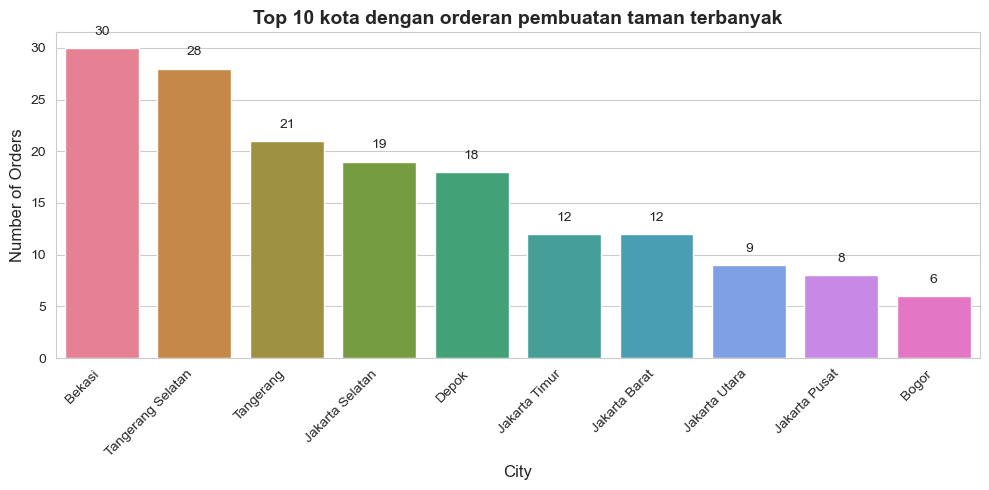

In [96]:
# Menampilkan barplot distribusi pesanan berdasarkan 10 kota teratas
plt.figure(figsize=(10, 5))
colors = sns.color_palette("husl", n_colors=len(top_10_cities))
sns.barplot(x=top_10_cities.index, y=top_10_cities.values, palette=colors)

# Menambahkan angka di atas setiap bar
for i, v in enumerate(top_10_cities.values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)

# Menambahkan label dan judul
plt.xlabel("City", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)
plt.title("Top 10 kota dengan orderan pembuatan taman terbanyak", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### Gardener dengan total biaya tenaga kerja tertinggi

In [98]:
# Menghitung total biaya tenaga kerja untuk setiap gardener, mengecualikan nama 'none'
gardener_labor_cost = df[df['name'] != 'none'].groupby('name')['total_biaya_tenaga_kerja'].sum().sort_values(ascending=False)
gardener_labor_cost

name
Ari aryana        27500000
Budi Wahyudi      25250000
ODIH              24250000
Abdul mujid       11500000
Roni sihanturi    10250000
Wandi obos         9500000
Wahyu Alvian       5500000
Martin             2000000
Ravi               1750000
Enjam jamhari      1000000
Name: total_biaya_tenaga_kerja, dtype: int64

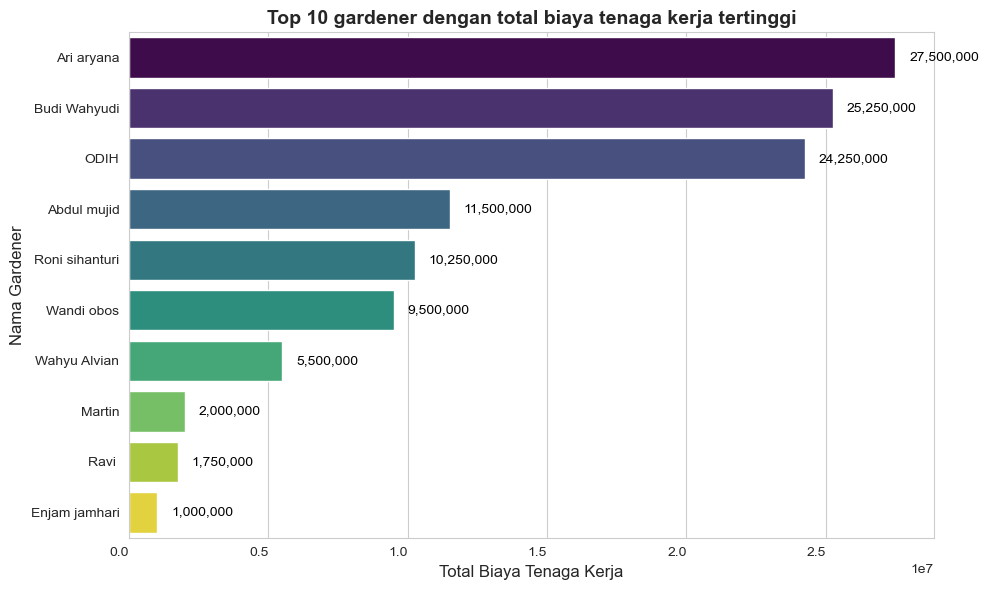

In [99]:
# Membuat barplot untuk 10 gardener dengan total biaya tenaga kerja tertinggi
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(gardener_labor_cost[:10])))
sns.barplot(y=gardener_labor_cost.index[:10], x=gardener_labor_cost.values[:10], palette=colors)

# Menambahkan label dan judul
plt.xticks(ha='right')
plt.xlabel("Total Biaya Tenaga Kerja", fontsize=12)
plt.ylabel("Nama Gardener", fontsize=12)
plt.title("Top 10 gardener dengan total biaya tenaga kerja tertinggi", fontsize=14, fontweight='bold')

# Menambahkan label angka pada setiap bar
for i, v in enumerate(gardener_labor_cost.values[:10]):
    plt.text(v + 500000, i, f"{v:,}", color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Conclusion

### Tren order pembuatan taman dari waktu ke waktu berdasarka lokasi

> Tren orderan pembangunan taman mengalami peningkatan signifikan dari bulan April hingga September, terutama di wilayah Jabodetabek. Namun, setelah bulan September, terjadi penurunan pesanan yang tajam. Wilayah Non Jabodetabek menunjukkan jumlah pesanan yang relatif stabil tetapi rendah sepanjang periode tersebut.

### Tren pertumbuhan revenue & gross profit dari waktu ke waktu

> Revenue meningkat dari 31,82 juta pada April ke puncak 482,80 juta pada September, lalu turun tajam ke 180,07 juta pada Oktober, dan sedikit naik kembali ke 273,26 juta pada November.

> Gross profit juga meningkat dari 13,90 juta pada April ke puncak 220,61 juta pada September, kemudian menurun tajam ke 75,98 juta pada Oktober, dan naik lagi ke 127,24 juta pada November.

> Secara keseluruhan, grafik menunjukkan tren peningkatan hingga September, diikuti oleh penurunan tajam pada Oktober, dan pemulihan sebagian pada November.

### Persentase order pembuatan taman berdasarkan provinsi

> Pesanan terbanyak berasal dari provinsi Jawa Barat dengan 33.5%, diikuti oleh Jakarta dengan 33.0%, dan Banten dengan 30.2%. Provinsi lainnya hanya menyumbang 3.3% dari total pesanan. Ini menunjukkan bahwa mayoritas pesanan terkonsentrasi di tiga provinsi utama, yaitu Jawa Barat, Jakarta, dan Banten.

### Kota dengan orderan pembuatan taman tertinggi

> Bekasi memimpin dengan jumlah pesanan tertinggi yakni 30 pesanan, sementara Bogor berada di posisi ke 10 dengan total 6 pesanan. Distribusi pesanan ini menunjukkan dominasi kota-kota besar di Jawa Barat dan sekitarnya dalam hal jumlah pesanan

### Gardener dengan total biaya tenaga kerja tertinggi

> Ari Aryana memiliki total biaya tenaga kerja tertinggi sebesar 27,500,000, diikuti oleh Budi Wahyudi dengan 25,250,000, dan ODIH dengan 24,250,000. Sebaliknya, Enjam Jamhari berada di urutan ke 10 memiliki total biaya tenaga kerja terendah di antara 10 gardener ini, yaitu sebesar 1,000,000 rupiah.